Using NCEI geoportal REST API to collect information about IOOS Regional Association archived data
==================

by Mathew Biddle, Faculty Specialist, UMD/ESSIC/CICS at the NOAA National Centers for Environmental Information (NCEI)

### IOOS regional associations archive their non-federal observational data with NOAA's National Center for Environmental Information (NCEI). In this notebook we will use the [RESTful](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) services of the [NCEI geoportal](https://www.nodc.noaa.gov/archivesearch/catalog/search/search.page) to collect metadata from the Archival Information Packages found in the NCEI archives. The metadata information are stored in [ISO 19115-2](https://wiki.earthdata.nasa.gov/display/NASAISO/ISO+19115-2) xml files which the NCEI geoportal uses for discovery of Archival Information Packages (AIPs). This example uses the ISO metadata records to display publication information as well as plot the time coverage of each AIP at NCEI which meets the search criteria.

First we import the owslib and numpy package. This allows us to parse the ISO xml records and process the information we gather.

In [1]:
# Importing packages. 
from owslib.iso import *
from owslib import util
import numpy as np

In [2]:
## start some variables and update others ##
i=0 # initialize i
accenos=[] # empty list
namespaces.update({'gmi':'http://www.isotc211.org/2005/gmi'}) # append gmi namespace to namespaces dictionary
namespaces.update({'gml': 'http://www.opengis.net/gml/3.2'})

### Now we select a Regional Association 
This is where the user identifies the Regional Association they are interested in. Simply uncomment the line that identifies the region of interest. The user can also omit the Regional Association to collect metadata information about all IOOS non-Federal observation data archived through the NCEI-IOOS pipeline.

In [3]:
##-----Select RA---##
#ra = "Great Lakes Observing System"
ra = "Southern California Coastal Ocean Observing System"
#ra = "Southeast Coastal Ocean Observing Regional Association"
#ra = "Pacific Islands Ocean Observing System"
#ra = "Northwest Association of Networked Ocean Observing Systems"

### Next we generate a geoportal query and georss feed
To find more information about how to compile a geoportal query, have a look at [REST API Syntax](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) and the [NCEI Search Tips](https://www.nodc.noaa.gov/search/granule/catalog/searchtips/searchtips.page) for the [NCEI geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page). The example provided is specfic to the NCEI-IOOS data pipeline project and only searches for non-federal timeseries data collected by each Regional Association. 

The query developed here can be updated to search for any Archival Information Packages at NCEI, therefore the user should develop the appropriate query using the [NCEI Geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page) and update this portion of the code to identify the REST API of interest.

In [7]:
import urllib
##----generate geoportal query and georss feed-----##
# base geoportal url
url1 = "https://data.nodc.noaa.gov/geoportal/rest/find/document?searchText=" 
# Identify the project: dataThemeprojects:"Integrated Ocean Observing System Data Assembly Centers Data Stewardship Program" 
url2 = "dataThemeprojects%3A%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22"
# Identify the Regional Association as perscribed above: AND "Northwest Association of Networked Ocean Observing Systems"
try:
    ra
except NameError:
    url3 = "%20"
else:
    url3 = "%%20AND%%20%%22%s%%22%%20" %urllib.parse.quote(ra)
# Identify the platform: AND "FIXED PLATFORM"
url4 = "AND%20%22FIXED%20PLATFORM%22"
# Identify the amount of records and format of the response: 1 to 1010 records 
url5 = "&start=1&max=1010"
# Identify the format of the response: georss
url6 = "&f=georss"
# Combine all into one url
url = url1+url2+url3+url4+url5+url6
print, "identified response format:'\n'", url,'\n'
print, "search page response:\n",url.replace(url6,"&f=searchPage")

(<function print>,
 'search page response:\n',
 'https://data.nodc.noaa.gov/geoportal/rest/find/document?searchText=dataThemeprojects%3A%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22%20AND%20%22Southern%20California%20Coastal%20Ocean%20Observing%20System%22%20AND%20%22FIXED%20PLATFORM%22&start=1&max=1010&f=searchPage')

### Time to query the portal and parse out the georrs response
Here we are opening the specified REST API and parsing it into a string. Then, since we identified it as a georss xml format above, we parse it using the etree package. We then pull out all the ISO metadata record links and print them out so the user can browse to the metadata record and look for what items they might be interested in.

In [9]:
## Query the NCEI Geoportal and parse the georss response##
import urllib

f = urllib.request.urlopen(url) # open georss response
url_string = f.read() # read response into string
url_root = etree.fromstring(url_string) # create etree object from georss response
iso_record = url_root.findall('channel/item/link') # find all iso record links
print, 'Found %i records' %len(iso_record)
for item in iso_record:
    print, item.text # print url to ISO19115-2 record

### Lets plot up what we have found
Now that we have all the ISO metadata records we are interested in, it's time to do something fun with them. In this example we want to generate a timeseries plot of the data coverage for the "Southern California Coastal Ocean Observing System" stations we have archived at NCEI.

First we set up the figure and import some modules to facilitate plotting and string parsing.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import re
import matplotlib.dates as mdates

fig = plt.figure(figsize=(15,12))

Next, we loop through each iso record to collect metadata information about each package. The example here shows how to collect the following items:
   1. NCEI Archival Information Package (AIP) Accession ID (7-digit Accession Number) 
   2. The first date the archive package was published.
   3. The platform code identified from the provider.
   4. The version number and date it was published.
   5. The current AIP size, in MB.
   6. The bounding time, for each AIP found.

There are plenty of other metadata elements to collect from the ISO records, so we recommend browsing to one of the records and having a look at the items of interest to your community.

Then, the process plots each AIP as a timeseries showing the time coverage. 

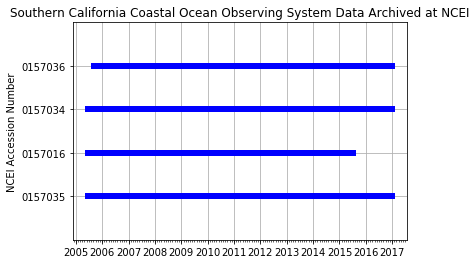

In [11]:
## Process each iso record ##
for item in iso_record: # for each accession in georss response
    iso_url = urllib.request.urlopen(item.text) #opens the iso xml web reference
    iso_tree = etree.ElementTree(file=urllib.request.urlopen(item.text)) #creates tree element
    root = iso_tree.getroot() # gets the root from tree element
    ident = root.find(util.nspath_eval('gmd:fileIdentifier/gco:CharacterString', namespaces)) # pulls out identifier string
    acce = re.search('[0-9]{7}',util.testXMLValue(ident)) # pulls out 7-digit accession number from identifier
    accenos.append(acce.group(0)) # adds accession number to accenos list
    print, "Accession Number = ", acce.group(0) # print the accession number

    ##-------Collect Publication date information----##
    date_path='gmd:identificationInfo/gmd:MD_DataIdentification/gmd:citation/gmd:CI_Citation/gmd:date/gmd:CI_Date/gmd:date/gco:Date'
    pubdate=root.find(util.nspath_eval(date_path, namespaces)) # first published date
    print, "First published date =",util.testXMLValue(pubdate)
    
    ##-------Collect Provider Platform Codes (if it has it)----##
    for tag in root.getiterator(util.nspath_eval('gco:CharacterString', namespaces)):
        #print dir(tag)
        if tag.text == "Provider Platform Codes":
            node=tag.getparent().getparent().getparent().getparent() # backs up to the MD_keywords element
            for item in node.findall(util.nspath_eval('gmd:keyword/gco:CharacterString', namespaces)):
                print, "Provider Platform Code = ", item.text
    
    ##------Pull out the version information------##
    # iterate through each processing step which is an NCEI version
    for tag in root.getiterator(util.nspath_eval('gmd:processStep', namespaces)):
        ## only parse gco:DateTime and gmd:title/gco:CharacterString
        vers_title='gmi:LE_ProcessStep/gmi:output/gmi:LE_Source/gmd:sourceCitation/gmd:CI_Citation/gmd:title/gco:CharacterString'
        vers_date='gmi:LE_ProcessStep/gmd:dateTime/gco:DateTime'
        if tag.findall(util.nspath_eval(vers_date, namespaces)) and \
        tag.findall(util.nspath_eval(vers_title, namespaces)): 
            # extract dateTime for each version
            datetimes=tag.findall(util.nspath_eval(vers_date, namespaces)) 
            # extract title string (contains version number)
            titles=tag.findall(util.nspath_eval(vers_title, namespaces)) 
            print, util.testXMLValue(titles[0]),"=",util.testXMLValue(datetimes[0])
    
    ##------Collect package size information ----#
    # iterate through transfersize nodes
    for tag in  root.getiterator(util.nspath_eval('gmd:transferSize', namespaces)):
        #print tag.find(util.nspath_eval('gco:Real', namespaces)).text
        if tag.find(util.nspath_eval('gco:Real', namespaces)).text: #only go into first gco:Real (where size exists)
            sizes=tag.find(util.nspath_eval('gco:Real', namespaces)) # extract size
            print, 'Current AIP Size =',sizes.text,'MB'
            break
        break # only use first size instance, all gco:Real attributes are the same

    for tag in root.getiterator(util.nspath_eval('gml:TimePeriod', namespaces)): # Bounding time for AIP
        #if text exists in begin or end position nodes.
        if tag.find(util.nspath_eval('gml:beginPosition', namespaces)).text and \
        tag.find(util.nspath_eval('gml:endPosition', namespaces)).text: #if text exists in begin or end position nodes.
            start_date = tag.find(util.nspath_eval('gml:beginPosition', namespaces)).text
            end_date = tag.find(util.nspath_eval('gml:endPosition', namespaces)).text
    print, "Bounding Time =",start_date,"TO",end_date,"\n"
    
    ## Plotting routine for each accession, plot start-end as timeseries for each accession
    # create datetime objects for start_date and end_date
    date1 = datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
    date2 = datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
    dates = [date1,date2]
    i += 1 # counter for plotting
    y = [i,i]
    plt.plot_date(x=dates, y=y,fmt='-',color='b',linewidth=6.0) # plot the timeseries

## Clean up the plot    
plt.ylim([0,i+1])
years = mdates.YearLocator() # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.grid(True)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt) # format the xaxis labels
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.grid(True)
ax.set(yticks=np.arange(1,len(accenos)+1))
ax.tick_params(which = 'both', direction = 'out')
ax.set_yticklabels(accenos)
plt.ylabel('NCEI Accession Number')
#plt.xlabel('Archival Information Package Coverage')
plt.title('%s Data Archived at NCEI'%ra)
plt.show()

This procedure has been developed as an example of how to use NCEI's geoportal REST API's to collect information about packages that have been archived at NCEI. The intention is to provide some guidance and ways to collect this information without having to request it directly from NCEI. There are a significant amount of metadata elements which NCEI makes available through their ISO metadata records. Therefore, anyone interested in collecting other information from the records at NCEI should have a look at the ISO metadata records and determine which items are of interest to their community. Then, update the example code provided to collect that information.
